In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

/home/naren/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def safe_norm(ivec,eps=10**-7,axis=-1):
    ovec = tf.reduce_sum(tf.square(ivec),axis=axis,keepdims=True)
    ovec = tf.sqrt(ovec + eps)
    return ovec
def squash(s_j, eps=10**-7, name = None, axis=-1):
    #v_j = (np.linalg.norm(s_j)**2/(1 + np.linalg.norm(s_j)**2)) * (s_j/np.linalg.norm(s_j))
    with tf.name_scope(name, default_name='squash'):
        sq_norm = tf.square(safe_norm(s_j,axis=axis))
        v_j = (sq_norm / (1 + sq_norm)) * (s_j/(safe_norm(s_j) + eps))
        return v_j


In [3]:
im_shape = (28,28,1)
k = 9

X = tf.placeholder(tf.float32,(None,) + im_shape)
num_pri_caps, num_pri_dims, num_dig_caps, num_dig_dims = 32*36, 8, 10, 16
#Feature extraction layer
c1 = tf.layers.Conv2D(256,(k,k),name='conv1')(X)
#Primary capsules
c2 = tf.layers.Conv2D(256,(k,k),strides=(2,2),name='conv2')(c1)
#c2 = tf.layers.Conv2D(256,(3,3),name='conv2')(c2)
pri_caps_raw = tf.reshape(c2, [-1,num_pri_caps,num_pri_dims], name = 'pri_caps_raw')
pri_caps_output = squash(pri_caps_raw)

#Digit capsules
init_sigma = 0.01
W_init = tf.random_normal(shape=(1,num_pri_caps,num_dig_caps,num_dig_dims, num_pri_dims),
                         stddev=init_sigma, dtype=tf.float32,name='W_init')
W = tf.Variable(W_init, name='W')
batch_size = tf.shape(X)[0]
#Following steps for one-shot matmul 
W_tiled = tf.tile(W,[batch_size,1,1,1,1],name='W_tiled')

'''
Reshape pri_cap output as column vector 
None,1152,8 to None,1152,8,1
'''

pri_caps_expanded = tf.expand_dims(pri_caps_output,-1,name='pri_caps_expanded')
'''
Add dimension for number of digit caps 
None,1152,8,1 to None,1152,1,8,1
'''
pri_caps_expanded = tf.expand_dims(pri_caps_expanded,2,name='pri_caps_expanded2')
'''None,1152,1,8,1 to None,1152,10,8,1'''
pri_caps_tiled = tf.tile(pri_caps_expanded, [1,1,num_dig_caps,1,1],name='pri_caps_tiled')

'''
Prediction u_j|i = dot(W_ij, u_i) --> Affine transform
where W_ij is a transformation matrix that will be learned
'''

dig_caps_predicted = tf.matmul(W_tiled,pri_caps_tiled,name='dig_caps_predicted')

##########-----ROUTING-----############

def condition(b_ij, v_j, counter, num_iterations):
    return counter < num_iterations
#Takes in routing weights and outputs updated weights
def routing(b_ij, agreement, counter, num_iterations):
    #c_i = softmax(b_i) --> along dig_caps dimension
    c_ij = tf.nn.softmax(b_ij,dim=2,name='routing_coeffs')

    '''
    s_j = sum(c_ij * u_j|i)
    where c_ij contains coupling coefficients 
    that will be determined by routing
    s_j is the raw output vector that represents the 
    instantiation parameters of each digit
    shape will be batch_size x 10 x 16 x 1
    '''
    #Keep_dims = true, otherwise s_j will be rank 4
    #==> Shape = None,1,10,16,1
    s_j = tf.reduce_sum(c_ij * dig_caps_predicted,axis=1,keepdims=True, name='weighted_sum')
    v_j = squash(s_j)
    #Make a copy of v_j for each primary capsule
    v_j_tiled = tf.tile(v_j,[1,num_pri_caps,1,1,1],name='v_j_tiled')
    agreement = tf.matmul(dig_caps_predicted,v_j_tiled,transpose_a=True,name='agreement')
    counter += 1
    return b_ij + agreement, v_j, counter, num_iterations

#extra ones at the end to keep it same rank as W
b_ij = tf.zeros([batch_size,num_pri_caps,num_dig_caps,1,1],dtype=tf.float32,name='b_ij')
num_iterations = 3
counter = tf.constant(0)
v_j=tf.zeros([batch_size,1,num_dig_caps,num_dig_dims,1],dtype=tf.float32,name='v_j_init')
#Dynamic loop keeps tf graph small
final_routing_weights, dig_caps_output, _,_ = tf.while_loop(condition,routing,[b_ij,v_j,counter,num_iterations])
y_prob = safe_norm(dig_caps_output,axis=-2)
y=tf.placeholder(tf.int32,shape=[None,1])
######----Margin Loss----#########
T = tf.one_hot(y,depth=num_dig_caps,name='T')
T = tf.reshape(T,tf.shape(y_prob))
m_pos = 0.9
m_neg = 0.1
lamb = 0.5
L_margin = tf.reduce_mean(tf.reduce_sum(T*tf.square(tf.maximum(0.,m_pos-y_prob)) + lamb*(tf.ones_like(T)-T) * tf.square(tf.maximum(0.,y_prob-m_neg)),axis=2))

#############-------------Decoder-----------------#######################
n_hidden = 512
n2_hidden = 1024
out_size = 28 * 28
alpha = 0.2
r_alpha = 0.0005
with tf.name_scope('decoder'):
    dc_in = tf.placeholder(tf.float32,shape=(None,16))
    dc_1 = tf.layers.Dense(n_hidden,input_shape=(None,16))(dc_in)#(tf.reshape(dig_caps_output[:,:,y[0][0],:,:],[-1,16]))
    dc_1 = tf.maximum(dc_1, alpha*dc_1)
    dc_2 = tf.layers.Dense(n2_hidden)(dc_1)
    dc_2 = tf.maximum(dc_2, alpha*dc_2)
    dc_out = tf.layers.Dense(out_size,activation=tf.nn.sigmoid)(dc_2)
    #Squared difference between reconstructed images and input images
    reconstruction_loss = tf.reduce_sum(tf.square(tf.reshape(X,[-1,out_size]) - dc_out))
L_total = L_margin + r_alpha*reconstruction_loss
#L_sum = tf.reduce_sum(L_total)
adam = tf.train.AdamOptimizer()
train = adam.minimize(L_total)
epochs = 50


Instructions for updating:
dim is deprecated, use axis instead


In [4]:
df = pd.read_csv('train.csv')

In [5]:
labels = np.asarray(df.label).reshape(42000,1)
train_x = np.asarray(df[df.columns[1:]])/255.0
saver = tf.train.Saver()

INFO:tensorflow:Restoring parameters from ../checkpoints/capsnet_v1.ckpt


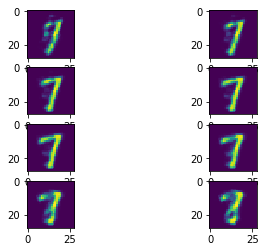

In [72]:
idx = 6
'''
Instantiation vectors test
IVs are tangled --> changing one vector affects image output in multiple ways

Tests changing single parameters
following are just for one particular image, different results for different images
idx 0 - 8 have tangled effects
idx 9 seems to affect thickness
idx 10 seems to squish image in the y-direction
idx 11 --> thickness again
idx 12 --> right-side thickness
idx 14 --> seems to deal with shape

Angle of IV encodes characteristics of image --> change multiple parameters to determine effect
angle between idx 8 and idx 9 --> thickness
angle between idx 7 and idx 9 --> clockwise rotation 

once again above results differed between images

IVs interact with one another in complex ways to produce output 
--> difficult to single out desired effects
'''
test = 9
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, '../checkpoints/capsnet_v1.ckpt')
    instantiation_vectors = sess.run(dig_caps_output,{X:train_x[idx].reshape((1,)+im_shape),y:labels[idx].reshape(1,1)})
    iv_current = instantiation_vectors[:,:,labels[idx],:,:].reshape((1,16))
    fig, ((p1,p2),(p3,p4),(p5,p6),(p7,p8)) = plt.subplots(4,2)
    p = (p1,p2,p3,p4,p5,p6,p7,p8)
    for i in range(8):
    #print(sess.run(tf.arg_max(tf.reduce_sum(instantiation_vectors,axis=-2),dimension=2)))
        iv_test = iv_current[:,:]
        iv_test[0][test] = -1. + 2/6. * i
        iv_test[0][test-1] = 1*(-1. + 2/6. * i)
        recon = sess.run(dc_out,{dc_in:iv_test})#X:train_x[idx].reshape((1,)+im_shape),y:labels[idx].reshape(1,1)})
  #  plt.imshow(tf.reshape(recon,[-1,28,28]))
        r = np.asarray(recon).reshape((28,28))
        p[i].imshow(r)
    recon = sess.run(dc_out,{dc_in:iv_test})#X:train_x[idx].reshape((1,)+im_shape),y:labels[idx].reshape(1,1)})
  #  plt.imshow(tf.reshape(recon,[-1,28,28]))
    r = np.asarray(recon).reshape((28,28))
    plt.imshow(r)
    #plt.imshow(recon[0].)

In [42]:

with tf.Session() as sess:
    try:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, '../checkpoints/capsnet_v1.ckpt')
        for e in range(epochs):
            print('Epoch ' + str(e))
            for i in range(40000):
                sess.run(train,{X:train_x[i].reshape((1,)+im_shape),y:labels[i].reshape(1,1)})
                if i%100==0:
                    #saver.save(sess,'./checkpoints/capsnet_v1.ckpt')
                    print('Loss: ' + str(sess.run(L_total,{X:train_x[i].reshape((1,)+im_shape),y:labels[i].reshape(1,1)})))
    except Exception as e1:
        print(e1)
    finally:
        #saver.save(sess,'./checkpoints/capsnet_v1.ckpt')
        print('Model saved')

INFO:tensorflow:Restoring parameters from ../checkpoints/capsnet_v1.ckpt
Epoch 0
Loss: 0.90251493
Loss: 0.6344007
Loss: 0.1525443
Loss: 0.2874337
Model saved


KeyboardInterrupt: 

In [17]:
y_prob.shape

TensorShape([Dimension(None), Dimension(1), Dimension(10), Dimension(1), Dimension(1)])

/home/naren/.local/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
